# Using News to Predict Short-term Stock Price Performance

In this project, our goal is to explore how financial news can be used to predict a company's short-term stock price performance compared to S&P 500 index. We tried some NLP and deep learning techniques to extract meaningful infomation from news data, together with market data, we built a predictive model and got positive test results. 

We will introduce this project in the following order:

### Content

- [Project Overview](#Project-Overview)
- [Related Works](#Related-Works)
- [Data Collection and Preprocessing](#Data-Collection-and-Preprocessing)
    - [News Data](#News-Data)
    - [Market Data](#Market-Data)
    - [Take a Look](#Take-a-Look-at-Data)
- [Deep Learning Model](#Deep-Learning-Model)
    - [Preparation](#Preparation)
    - [Model Construction and Training](#Model-Construction-and-Training)
    - [Test Results](#Test-Results)
- [Conclusion and Future Works](#Conclusion-and-Future-Works)
- [References](#References)

In [1]:
# data preprocessing and visualization
import pandas as pd
import numpy as np
import joblib
import requests
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from collections import defaultdict
import intrinio_sdk
import datetime
from tqdm import tqdm
import io
from time import sleep
from requests_html import HTMLSession
from textblob import TextBlob
from random import randint
from wordcloud import WordCloud,STOPWORDS
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')


# deep learning model
import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Dense, Dropout, Input, Embedding, Flatten, BatchNormalization, concatenate
from keras.layers import CuDNNGRU, Bidirectional
from keras.optimizers import Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

[nltk_data] Downloading package stopwords to /home/ubuntu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/ubuntu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ubuntu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!



Using TensorFlow backend.


# Project Overview

Predicting stock market prices has been a topic of interest among both analysts and researchers for a long time. Stocks are hard to predict because of their high volatile nature which depends on diverse political and economic factors, change of leadership, investor sentiment, and many other factors. We believe that financial news is also one of these factors. It is hard for investors to decide the trend of stock prices based on the huge amount of news. But taking advantage of NLP and deep learning, we can do research on the relationship between financial news and stocks. However, stock pricing prediction is still proved to be infeasible. As a result, we decided to predict the stock price __movement__ instead. The prediction will be based on historical stock price data along with textual data.

The definition of **Movement** (which is the label in this project):

$$ \text{Percentage of change for Company} = \frac{(\text{Next business day’s open price} – \text{Today’s close price})}{\text{Today’s close price}}\times100\%$$

$$ \text{Normalized percentage of change} = \text{Percentage of change for Company} - \text{Percentage of change for S&P500} $$

$$ \text{Movement} = \begin{cases}
    Up\space(1) & \text{ if  } \text{Normalized percentage of change}>1
\\  Down\space(-1) & \text{ if  } \text{Normalized percentage of change}<-1
\\  Flat\space(0) & \text{ if  } \text{Normalized percentage of change}\in(-1, 1)
\end{cases}$$

# Related Works

In recent year, many researchers tried to explore the possibility of using news or other text data to predict stock price.

Yusuf Aktan implemented four machine learning architectures in [Using NLP and Deep Learning to Predict Stock Price Movements](https://towardsdatascience.com/using-nlp-and-deep-learning-to-predict-the-stock-market-64eb9229e102) including CNN, RNN, MLP and CNN-RNN[1]. Instead of using financial news, his unstructured text data were SEC 8-K documents.The 8-K is a report mandated by the SEC(Securities and Exchange Commission) that companies must use to inform their shareholders of changes in their business. We refered his definition of stock movement.

Saloni Mohan and other authors of [Stock Price Prediction Using News Sentiment Analysis](https://ieeexplore.ieee.org/document/8848203) proved that there is a strong correlation between news articles related to a company and its stock price movements both from previous research and their own study[2]. They collected news articles for S&P 500 companies February 2013 to March 2017 from international daily newspaper websites. They extracted ﬁve sentences surrounding the name of the company in articles in which the name of the company appeared. For articles only containing the company name in the title, they considered the whole article. And they applied a log transformation on the stock prices to reduce the difference between high and low stock prices.

By studying the above studies and evaluate the feasibility of time and budget, this report focuses on part of companies in S&P 500 and the relevant financial news from 12/2/2018 to 12/2/2019.

### What's different?

Our main difference from other studies using news to predict stock price is that we focused on the **short-term** stock price performance **compared to the market** (S&P 500 index), instead of directly predict the change of stock price. Besides, we tried to use the **full content** of news articles as a input and extract information from it in our own model, rather than only use some related features like word count, sentiment, title as input.

# Data Collection and Preprocessing

There are mainly two parts of data we collected: **financial news** and **market (stock) data**

We used two APIs for data collection:

- [Intrinio](https://intrinio.com/): This API returns financial news acoording to each stock company along with the URLs and summary.

- [Alpha vantage](https://www.alphavantage.co/): This API returns daily time series (date, daily open, daily high, daily low, daily close, daily volume) of the global equity specified, covering 20+ years of historical data.

Additionally, we found that historical index prices for the VIX, S&P500 and GICS Sectors can be considered as vital features related to stock movement. 
- __VIX__ is a popular measure of the stock market's expectation of volatility implied by S&P 500 index options. It is calculated and disseminated on a real-time basis by the Chicago Board Options Exchange, and is commonly referred to as the fear index or the fear gauge.
- __S&P500__ index is a stock market index that measures the stock performance of 500 large companies listed on stock exchanges in the United States. It is one of the most commonly followed equity indices, and many consider it to be one of the best representations of the U.S. stock market.
- __GICS__ (Global Industry Classification Standard) is an industry taxonomy developed in 1991 by MSCI and Standard & Poor's for use by the global financial community.

We downloaded them from [Yahoo Finance](https://finance.yahoo.com/).

## News Data

We used Intrinio api to get news data of different companies, which was able to search the news using company ticker symbol.

For each news, we can get 5 fields ([detailed documentation](https://docs.intrinio.com/documentation/web_api/get_company_news_v2)): 
* id: The Intrinio ID for the news article
* title: The title of the news article
* **publication_date**: The publication date of the news article
* **url**: The url of the news article
* **summary**: A summary of the news article

However, when exploring the API, we found that only 29 companies' data are available to a free account. As a result, we used these 29 companies' data in our project.

In [2]:
# Load company list (29 ticker symbols)
with open('tickers_with_news.csv') as f:
    companies = []
    for line in f.readlines():
        companies.append(line.strip('\n'))

print('29 Companies:')
print(companies)

29 Companies:
['MMM', 'AXP', 'AAPL', 'BA', 'CAT', 'CVX', 'CSCO', 'KO', 'XOM', 'GE', 'GS', 'HD', 'INTC', 'IBM', 'JNJ', 'JPM', 'MCD', 'MRK', 'MSFT', 'NKE', 'PFE', 'PG', 'TRV', 'UNH', 'UTX', 'VZ', 'V', 'WMT', 'DIS']


Then we made API requests to get all the news data of the above 29 companies published between 12/2/2018 to 12/2/2019, and store them to a dictionary. After that, we got 116700 news objects in total.

In [5]:
intrinio_sdk.ApiClient().configuration.api_key['api_key'] = 'OjgzODBiYzExZDQ5ZjQ2MmViNTI3MjJkZWVmMzI3ODg4'
company_api = intrinio_sdk.CompanyApi()

# Get all the news data of a company between 12/2/2018 to 12/2/2019 from intrinio api
def get_company_news(company, news_dict):
    earlist = datetime.datetime(2018, 12, 2)
    last_date = datetime.datetime(2019, 12, 2)
    next_page = ''
    while last_date > earlist:
        try:
            api_response = company_api.get_company_news(identifier=company, page_size=100, next_page=next_page)
            news_dict[company].extend(api_response.news)
            last_date = api_response.news[-1].publication_date.replace(tzinfo=None)
            next_page = api_response.next_page
        except Exception as e:
            print('limit exceeds')
            sleep(5)

# Get all the news data of all 29 companies from intrinio api
news_dict = defaultdict(list)
total_count = 0
for company in companies:
    print('Getting news of %s ...'%company)
    get_company_news(company, news_dict)
    total_count += len(news_dict[company])
print("Total number of news:", total_count)

Getting news of MMM ...
Getting news of AXP ...
Getting news of AAPL ...
Getting news of BA ...
Getting news of CAT ...
limit exceeds
Getting news of CVX ...
Getting news of CSCO ...
Getting news of KO ...
Getting news of XOM ...
Getting news of GE ...
Getting news of GS ...
Getting news of HD ...
Getting news of INTC ...
Getting news of IBM ...
Getting news of JNJ ...
Getting news of JPM ...
Getting news of MCD ...
Getting news of MRK ...
Getting news of MSFT ...
Getting news of NKE ...
Getting news of PFE ...
Getting news of PG ...
Getting news of TRV ...
Getting news of UNH ...
Getting news of UTX ...
Getting news of VZ ...
Getting news of V ...
Getting news of WMT ...
Getting news of DIS ...
Total number of news: 116700


We can only get a summary of each news from this API, which is usually one sentence or a short paragraph

For example:

*"Apple will be hosting its annual autumn event at its Cupertino, California headquarters on Sept. 10.  Much like in years past, the company is expected to unveil new iPhones, Apple Watches, and perhaps a few other gadgets.  It pretty much goes without saying at this point that Apple will release a new iPhone come September."*

In order to get more information of the news, we decided to retrive the full content of the news from the URL using web scraping. Since around 70% of the news in the Intrinio API are from [*Yahoo Finance*](https://finance.yahoo.com/), to simplify the work of web scraping, we only kept the news data and got the full text of news from *Yahoo Finance*. (The following code cells may take more than 10 hours to run)

In [6]:
# Scrape news text from a given yahoo finance news url
session = HTMLSession()
def get_yahoo_news_text(url):
    r = session.get(url)
    text = []
    for p in r.html.find("p[class='canvas-atom canvas-text Mb(1.0em) Mb(0)--sm Mt(0.8em)--sm']"):
        text.append(p.text)
    for p in r.html.find("p[class='canvas-text Mb(1.0em) Mb(0)--sm Mt(0.8em)--sm canvas-atom']"):
        text.append(p.text)
#     if len(text)==0: print("Not found:", url)
    return " ".join(text)

# Get yahoo finance news from a news list
def get_yahoo_news(ticker, news_list):
    date_list = []
    summary_list = []
    title_list = []
    text_list = []

    for news in news_list:
        if news.url.startswith('https://finance.yahoo.com/'):
            date_list.append(news.publication_date.replace(tzinfo=None))
            summary_list.append(news.summary)
            title_list.append(news.title)
            text_list.append(get_yahoo_news_text(news.url))

    df = pd.DataFrame(
      {
          "ticker" : [ticker]*len(date_list),
          "date" : date_list,
          "summary": summary_list,
          "title": title_list,
          "text": text_list
      }
    )
    return df

In [7]:
df_list = []
for company in companies:
    print('Getting Yahoo news of %s ...'%company)
    df_list.append(get_yahoo_news(company, news_dict[company]))
df = pd.concat([item for item in df_list])
print("Total number of Yahoo Finance news:", len(df))

Getting Yahoo news of MMM ...
Getting Yahoo news of AXP ...
Getting Yahoo news of AAPL ...
Getting Yahoo news of BA ...
Getting Yahoo news of CAT ...
Getting Yahoo news of CVX ...
Getting Yahoo news of CSCO ...
Getting Yahoo news of KO ...
Getting Yahoo news of XOM ...
Getting Yahoo news of GE ...
Getting Yahoo news of GS ...
Getting Yahoo news of HD ...
Getting Yahoo news of INTC ...
Getting Yahoo news of IBM ...
Getting Yahoo news of JNJ ...
Getting Yahoo news of JPM ...
Getting Yahoo news of MCD ...
Getting Yahoo news of MRK ...
Getting Yahoo news of MSFT ...
Getting Yahoo news of NKE ...
Getting Yahoo news of PFE ...
Getting Yahoo news of PG ...
Getting Yahoo news of TRV ...
Getting Yahoo news of UNH ...
Getting Yahoo news of UTX ...
Getting Yahoo news of VZ ...
Getting Yahoo news of V ...
Getting Yahoo news of WMT ...
Getting Yahoo news of DIS ...
Total number of Yahoo Finance news: 71940


For those news pages which we cannot any news text (because news page being deleted or only contain images/videos), we used the summary as its content.

In [8]:
df.loc[df['text']=='', 'text'] = df.loc[df['text']=='', 'summary']

After that, we got 71940 *Yahoo Finance* news in total:

In [9]:
joblib.dump(df, 'news_data')
# df = joblib.load('news_data')
df.head()

,ticker,date,summary,title,text
0,MMM,2019-11-29 23:25:00,It’s time to comb through your portfolio and d...,4 Stocks to Unload Before the Year-End Tax-Sel...,It’s time to comb through your portfolio and d...
1,MMM,2019-11-29 23:14:28,General Electric is making major changes after...,Is GE Stock A Buy Right Now? Here's What Earni...,General Electric is making major changes after...
2,MMM,2019-11-29 00:00:28,Russell 2000 ETF (IWM) lagged the larger S&P 5...,Do Hedge Funds Really Love 3M Company (MMM)?,Russell 2000 ETF (IWM) lagged the larger S&P 5...
3,MMM,2019-11-27 16:37:31,(Bloomberg Opinion) -- Deere & Co. results sho...,Deere's Dour Outlook Tests Faith in Manufactur...,(Bloomberg Opinion) -- Deere & Co. results sho...
4,MMM,2019-11-26 17:43:28,"Shares of AbbVie, Texas Instruments, Extra Spa...",Best Dividend Stocks for December 2019,"Shares of AbbVie, Texas Instruments, Extra Spa..."


With the full content of news, we used [TextBlob](https://textblob.readthedocs.io/en/dev/), a popular Python library for processing textual data, to do [sentiment analysis](https://en.wikipedia.org/wiki/Sentiment_analysis) for each news text. We took the polarity score (a float within the range [-1.0, 1.0], representing negative -> neutral -> positive) from the analysis result as a new feature.

Then we transformed the news text to a sequence of words by removing [stop words](https://en.wikipedia.org/wiki/Stop_words) (given by [NLTK stopword list](https://gist.github.com/sebleier/554280) from the news text, [tokenized](https://en.wikipedia.org/wiki/Lexical_analysis#Tokenization) the text and [lemmatized](https://en.wikipedia.org/wiki/Lemmatisation) each token.

We also counted the number of words of the processed text as a new feature.

In [10]:
def get_sentiment(string):
    s = TextBlob(string)
    return s.sentiment.polarity

stop_words = stopwords.words("english")
wordnet_lemmatizer = WordNetLemmatizer()
punctuations = string.punctuation
def nltk_tokenizer(text):
    tokens = [word for word in word_tokenize(text) if word.isalpha()]
    tokens = list(filter(lambda t: t not in punctuations, tokens))
    tokens = list(filter(lambda t: t.lower() not in stop_words, tokens))
    filtered_tokens = list(map(lambda token: wordnet_lemmatizer.lemmatize(token.lower()), tokens))
    return filtered_tokens

def get_date(date_time):
    return date_time.date()

In [11]:
df['sentiment'] = df['text'].map(get_sentiment)
df['processed_text'] = df['text'].map(nltk_tokenizer)
df['word_count'] = df['processed_text'].map(lambda x: len(x))
df['date'] = df['date'].map(get_date)

#### News DataFrame

In [12]:
df.head()

,ticker,date,summary,title,text,sentiment,processed_text,word_count
0,MMM,2019-11-29,It’s time to comb through your portfolio and d...,4 Stocks to Unload Before the Year-End Tax-Sel...,It’s time to comb through your portfolio and d...,-0.075000,"[time, comb, portfolio, decide, year, loser, p...",12
1,MMM,2019-11-29,General Electric is making major changes after...,Is GE Stock A Buy Right Now? Here's What Earni...,General Electric is making major changes after...,-0.190625,"[general, electric, making, major, change, bru...",15
2,MMM,2019-11-29,Russell 2000 ETF (IWM) lagged the larger S&P 5...,Do Hedge Funds Really Love 3M Company (MMM)?,Russell 2000 ETF (IWM) lagged the larger S&P 5...,0.152554,"[russell, etf, iwm, lagged, larger, p, etf, sp...",599
3,MMM,2019-11-27,(Bloomberg Opinion) -- Deere & Co. results sho...,Deere's Dour Outlook Tests Faith in Manufactur...,(Bloomberg Opinion) -- Deere & Co. results sho...,0.026289,"[bloomberg, opinion, deere, result, show, trou...",422
4,MMM,2019-11-26,"Shares of AbbVie, Texas Instruments, Extra Spa...",Best Dividend Stocks for December 2019,"Shares of AbbVie, Texas Instruments, Extra Spa...",0.150000,"[share, abbvie, texas, instrument, extra, spac...",12


In [13]:
joblib.dump(df, 'processed_news_data')

## Market Data

#### Collect GICS Sectore Data

In [14]:
wiki_url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
cik_df = pd.read_html(wiki_url,header=0,index_col=0)[0]
cik_df['GICS Sector'] = cik_df['GICS Sector'].astype("category")
cik_df['GICS Sub Industry'] = cik_df['GICS Sector'].astype("category")
tickers = cik_df.index.drop_duplicates().values
cik_df.to_csv("GICS.csv")
cik_df.head()

,Security,SEC filings,GICS Sector,GICS Sub Industry,Headquarters Location,Date first added,CIK,Founded
Symbol,,,,,,,,
MMM,3M Company,reports,Industrials,Industrials,"St. Paul, Minnesota",NaN,66740,1902
ABT,Abbott Laboratories,reports,Health Care,Health Care,"North Chicago, Illinois",1964-03-31,1800,1888
ABBV,AbbVie Inc.,reports,Health Care,Health Care,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
ABMD,ABIOMED Inc,reports,Health Care,Health Care,"Danvers, Massachusetts",2018-05-31,815094,1981
ACN,Accenture plc,reports,Information Technology,Information Technology,"Dublin, Ireland",2011-07-06,1467373,1989


#### Load VIX data

In [15]:
vix_df = pd.read_csv("VIX.csv",parse_dates=['Date'],index_col="Date")
vix_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-12-04,11.05,11.86,10.26,11.68,11.68,0
2017-12-05,11.38,11.67,10.65,11.33,11.33,0
2017-12-06,11.63,11.68,10.86,11.02,11.02,0
2017-12-07,10.90,11.32,10.12,10.16,10.16,0
2017-12-08,10.00,10.06,9.43,9.58,9.58,0


#### Collect Stock Price Data from Alpha vantage API

In [17]:
key = "VS0UT0N9RKYOH81I"
base_url = "https://www.alphavantage.co/query?"
params = {"function":"TIME_SERIES_DAILY_ADJUSTED",
          "datatype":"csv",
          "outputsize":"full",
          "apikey": key}
all_tickers = dict()
tickers_with_news = pd.read_csv("./tickers_with_news.csv",header=None)
tickers_with_news = list(tickers_with_news[0].values)

for ticker in tqdm(tickers_with_news):
    params["symbol"] = ticker
    r = requests.get(base_url,params)
    filepath = io.StringIO(r.content.decode('utf-8'))
    av_df = pd.read_csv(filepath,parse_dates=True,index_col=[0],error_bad_lines=False)
    all_tickers[ticker] = av_df
    sleep(randint(20,100))
    
all_tickers_data = pd.concat(all_tickers)
# all_tickers_data.to_csv("all_tickers_data.csv",chunksize=50)

all_tickers_data

open     high       low   close  adjusted_close  \
ticker Date                                                             
MMM    2019-12-03  166.500  166.600  164.4000  165.00        165.0000   
       2019-12-02  170.160  171.700  168.2400  168.27        168.2700   
       2019-11-29  170.430  170.580  169.2600  169.77        169.7700   
       2019-11-27  170.000  171.370  169.5100  170.61        170.6100   
       2019-11-26  169.800  170.250  168.7100  169.23        169.2300   
       2019-11-25  168.470  170.355  167.8710  170.24        170.2400   
       2019-11-22  165.500  167.750  165.0000  167.60        167.6000   
       2019-11-21  166.880  167.000  164.5100  165.14        165.1400   
       2019-11-20  169.790  170.000  167.1500  167.77        166.3197   
       2019-11-19  171.720  171.720  169.5300  170.68        169.2046   
       2019-11-18  170.790  171.195  169.1700  170.54        169.0658   
       2019-11-15  171.660  172.690  171.0400  171.88        170.3942   
       2019-11-14  169.980  172.320  169.9300  170.93        169.4524   
       2019-11-13  170.110  171.390  169.5800  170.55        169.0757   
       2019-11-12  170.360  172.070  170.0300  170.84        169.3632   
       2019-11-11  172.500  172.500  169.6500  170.11        168.6395   
       2019-11-08  174.580  174.870  172.1100  173.15        171.6532   
       2019-11-07  175.730  176.710  173.7900  174.52        173.0114   
       2019-11-06  174.910  175.000  172.3600  174.00        172.4959   
       2019-11-05  175.000  175.460  173.7700  175.27        173.7549   
       2019-11-04  171.620  175.000  171.6200  174.90        173.3881   
       2019-11-01  166.940  170.150  166.7200  170.09        168.6197   
       2019-10-31  168.510  168.560  163.5500  164.99        163.5637   
       2019-10-30  168.230  168.570  167.0300  168.37        166.9145   
       2019-10-29  168.030  169.950  167.5100  168.81        167.3507   
       2019-10-28  166.480  169.710  166.2000  169.06        167.5986   
       2019-10-25  162.510  167.630  162.1300  166.09        164.6542   
       2019-10-24  165.160  165.250  159.6311  161.89        160.4905   
       2019-10-23  167.410  168.760  166.5600  168.76        167.3012   
       2019-10-22  166.270  168.905  165.1000  167.54        166.0917   
...                    ...      ...       ...     ...             ...   
DIS    2018-01-17  111.200  112.210  110.5650  111.97        109.5367   
       2018-01-16  113.070  113.160  110.6200  110.69        108.2845   
       2018-01-12  111.320  112.720  111.0000  112.47        110.0258   
       2018-01-11  110.250  111.080  109.5100  110.99        108.5780   
       2018-01-10  109.960  110.500  109.0100  109.47        107.0910   
       2018-01-09  110.130  110.860  109.8600  109.94        107.5508   
       2018-01-08  110.890  111.280  109.5400  110.02        107.6291   
       2018-01-05  112.680  112.680  111.2400  111.62        109.1943   
       2018-01-04  112.950  113.000  111.6300  112.23        109.7911   
       2018-01-03  112.190  113.190  111.4500  112.28        109.8400   
       2018-01-02  108.950  111.810  108.5600  111.80        109.3704   
       2017-12-29  108.050  108.340  107.5100  107.51        105.1736   
       2017-12-28  108.000  108.050  107.0600  107.77        105.4280   
       2017-12-27  108.420  108.550  107.4550  107.64        105.3008   
       2017-12-26  108.490  109.370  107.8900  108.12        105.7704   
       2017-12-22  109.400  109.685  108.4500  108.67        106.3084   
       2017-12-21  109.520  111.090  109.1892  109.57        107.1889   
       2017-12-20  111.625  112.300  109.6900  109.69        107.3063   
       2017-12-19  111.050  112.390  110.7700  111.81        109.3802   
       2017-12-18  111.850  111.990  110.3050  111.03        108.6171   
       2017-12-15  111.805  112.000  110.6000  111.27        108.8519   
       2017-12-14  107.750  111.540  107.2000  110.57        108.1671   
       

#### Import S&P 500 data

In [18]:
gspc = pd.read_csv("GSPC.csv",parse_dates=['Date'],index_col="Date")
gspc['Open_next'] = gspc['Open'].shift(-1)
gspc['change_%'] = ((gspc['Open_next'] - gspc['Adj Close'])/gspc['Adj Close'])*100
gspc.head()

,Open,High,Low,Close,Adj Close,Volume,Open_next,change_%
Date,,,,,,,,
2017-12-04,2657.189941,2665.189941,2639.030029,2639.439941,2639.439941,4023150000,2639.780029,0.012885
2017-12-05,2639.780029,2648.719971,2627.729980,2629.570068,2629.570068,3539040000,2626.239990,-0.126640
2017-12-06,2626.239990,2634.409912,2624.750000,2629.270020,2629.270020,3229000000,2628.379883,-0.033855
2017-12-07,2628.379883,2640.989990,2626.530029,2636.979980,2636.979980,3292400000,2646.209961,0.350021
2017-12-08,2646.209961,2651.649902,2644.100098,2651.500000,2651.500000,3106150000,2652.189941,0.026021


We calculate percentage of change and normalize the change for all stock data by subtracting the change during the same time for the S&P 500 index. The normalized changes were labeled as either “**up**(1)” (> 1%), “**down**(-1)” (< -1% ), or “**flat**(0)“ (between -1% and 1%).

Moreover, we created 4 features manually which are average historical movement in different time period (7, 16, 32, 64 weekdays ago) with different window size (3 or 10 days), in order to consider the stock's historical trend when predicting.

In [19]:
all_tickers_data['open_next'] = all_tickers_data['open'].groupby("ticker").shift(1)
all_tickers_data['change_%'] = ((all_tickers_data['open_next']-all_tickers_data['adjusted_close'])/all_tickers_data['adjusted_close'])*100
df = pd.merge(all_tickers_data, gspc, left_index=True, right_index=True).drop(['Close','Volume','High','Low','volume','high','low','close','dividend_amount','split_coefficient'], axis=1)
df = df.rename({'change_%_x':'change_%_ticker','change_%_y':"change_%_index"},axis='columns')
df['normalize_change'] = df['change_%_ticker']-df['change_%_index']

def get_change(pct):
    if pct > 1: return 1
    if pct < -1: return -1
    return 0

df['change'] = df['normalize_change'].map(get_change)
df.head()

open  adjusted_close  open_next  change_%_ticker  \
ticker Date                                                             
MMM    2019-12-02  170.16          168.27     166.50        -1.051881   
       2019-11-29  170.43          169.77     170.16         0.229723   
       2019-11-27  170.00          170.61     170.43        -0.105504   
       2019-11-26  169.80          169.23     170.00         0.455002   
       2019-11-25  168.47          170.24     169.80        -0.258459   

                          Open    Adj Close    Open_next  change_%_index  \
ticker Date                                                                
MMM    2019-12-02  3143.850098  3113.870117          NaN             NaN   
       2019-11-29  3147.179932  3140.979980  3143.850098        0.091377   
       2019-11-27  3145.489990  3153.629883  3147.179932       -0.204525   
       2019-11-26  3134.850098  3140.520020  3145.489990        0.158253   
       2019-11-25  3117.439941  3133.639893  3134.850098        0.038620   

                   normalize_change  change  
ticker Date                                  
MMM    2019-12-02               NaN       0  
       2019-11-29          0.138346       0  
       2019-11-27          0.099021       0  
       2019-11-26          0.296749       0  
       2019-11-25         -0.297078       0

In [20]:
df = df.dropna()
# rolling average for +-3 days 
df_normalize = pd.DataFrame(df['normalize_change'])
df_normalize = df_normalize.rolling(3,min_periods=1).mean()

df_rolling5 = pd.DataFrame(df['normalize_change'])
df_rolling5 = df_normalize.rolling(10,min_periods=1,center=True).mean()

df['rolling_3'] = df_normalize['normalize_change'] # label
df['rolling_+5-5'] = df_rolling5['normalize_change']
df['his_1'] = df['rolling_3'].groupby("ticker").shift(-8)
df['his_2'] = df['rolling_+5-5'].groupby("ticker").shift(-16)
df['his_3'] = df['rolling_+5-5'].groupby("ticker").shift(-32)
df['his_4'] = df['rolling_+5-5'].groupby("ticker").shift(-64)
df = df.dropna()
df.head()
df.to_csv('stock.csv')

open  adjusted_close  open_next  change_%_ticker  \
ticker Date                                                             
MMM    2019-11-29  170.43          169.77     170.16         0.229723   
       2019-11-27  170.00          170.61     170.43        -0.105504   
       2019-11-26  169.80          169.23     170.00         0.455002   
       2019-11-25  168.47          170.24     169.80        -0.258459   
       2019-11-22  165.50          167.60     168.47         0.519093   

                          Open    Adj Close    Open_next  change_%_index  \
ticker Date                                                                
MMM    2019-11-29  3147.179932  3140.979980  3143.850098        0.091377   
       2019-11-27  3145.489990  3153.629883  3147.179932       -0.204525   
       2019-11-26  3134.850098  3140.520020  3145.489990        0.158253   
       2019-11-25  3117.439941  3133.639893  3134.850098        0.038620   
       2019-11-22  3111.409912  3110.290039  3117.439941        0.229879   

                   normalize_change  change  rolling_3  rolling_+5-5  \
ticker Date                                                            
MMM    2019-11-29          0.138346       0   0.138346      0.112852   
       2019-11-27          0.099021       0   0.118683      0.091630   
       2019-11-26          0.296749       0   0.178039      0.106614   
       2019-11-25         -0.297078       0   0.032897      0.127588   
       2019-11-22          0.289214       0   0.096295      0.196934   

                      his_1     his_2     his_3     his_4  
ticker Date                                                
MMM    2019-11-29  0.751706  0.945291  0.836041  1.158972  
       2019-11-27  0.744403  1.014478  0.925828  1.125579  
       2019-11-26  0.882839  1.039348  1.016882  1.107641  
       2019-11-25  0.631128  1.022568  0.978454  1.085567  
       2019-11-22  0.756026  0.991664  0.913989  1.082001

## Take a Look at Data
### Stock Data

We used data from 12/02/2018 to 12/02/2019. Let's take Apple as an example to look at. 

Here is how the normalized the stock price change comparing to its original and SP500.

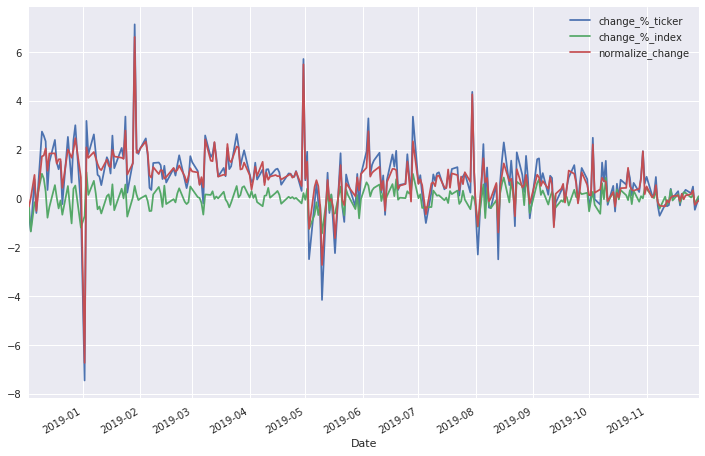

In [22]:
df1 = df[df.index.get_level_values(1) >= '2018-12-03 00:00:00'].loc['AAPL']
df1.plot(y=['change_%_ticker','change_%_index','normalize_change'],figsize=(12,8))

Distribution of normalized change percentage:

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


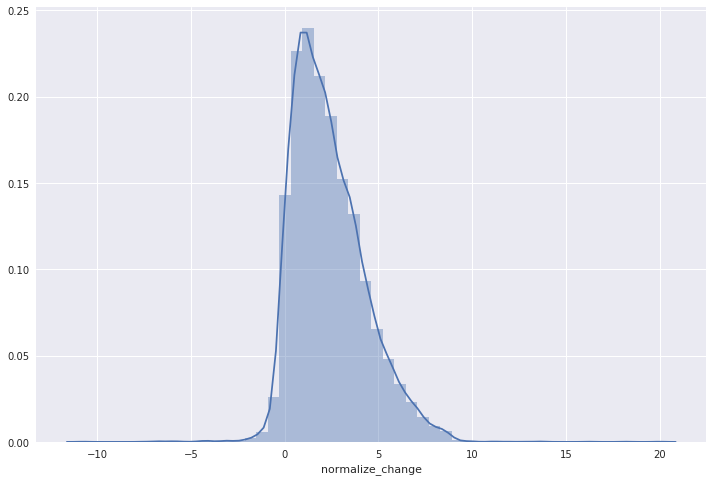

In [23]:
sns.set(rc={'figure.figsize':(12,8)})
sns.distplot(df['normalize_change'])

By ploting the distribution of all movements, we can see that a extreme unbalance exists, which is because these companies in S&P500 performed stable and better than others. This suggests we should use some method like oversampling to handle this problem before conduct the model.

([<matplotlib.patches.Wedge at 0x7ff8522ae668>,
 [Text(-0.731873231163754, 0.8211952103525242, '1'),
  Text(0.7148231554379002, -0.8360788577938111, '0'),
  Text(1.0997671710907395, -0.022631159737679592, '-1')])

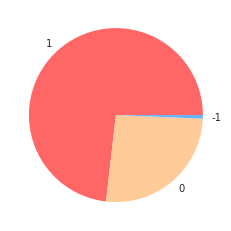

In [24]:
fig = plt.gcf()
fig.set_size_inches(4,4)
plt.pie(df['change'].value_counts(), labels=df['change'].value_counts().index,colors = ['#ff6666', '#ffcc99',  '#66b3ff'])

Then here is what the rolling average of 10 days around the date like.

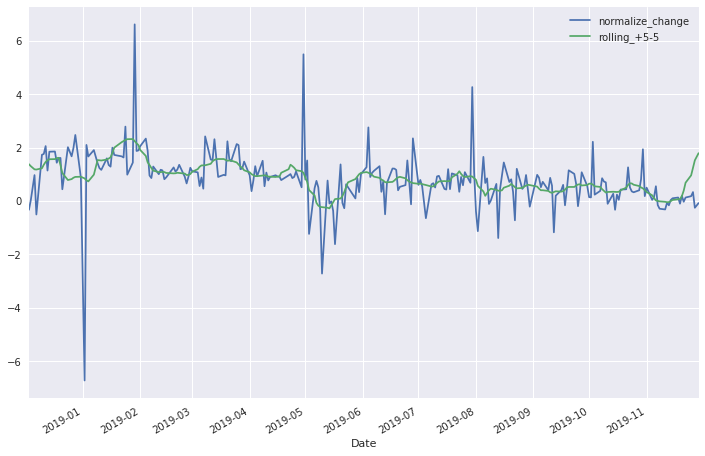

In [25]:
df1.plot(y=['normalize_change','rolling_+5-5'],figsize=(12,8))

### News Data

Word cloud for apple after updating stopwords for Apple:

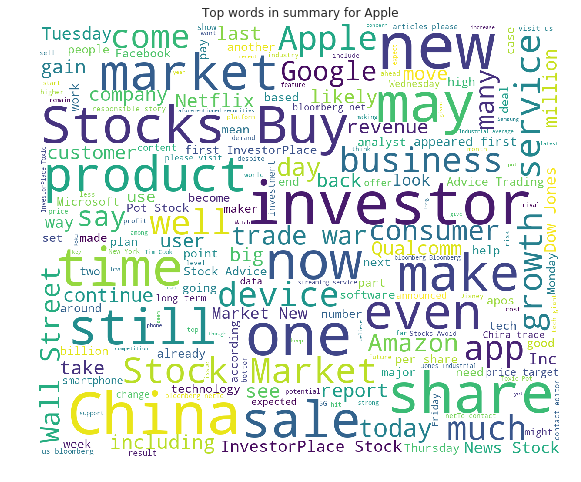

In [26]:
news_data = joblib.load('processed_news_data')
news_data['date'] = pd.to_datetime(news_data['date'])

stopwords = set(STOPWORDS)
stopwords.update(["AAPL","Apple", "companies", "apple",'iphone','Iphone','company','will','said','year','quot'])
text = ' '.join(news_data[news_data.ticker=='AAPL']['summary'].values)
wordcloud = WordCloud(max_font_size=150, stopwords=stopwords,background_color='white',
                      width=1200, height=1000).generate(text)
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud)
plt.title('Top words in summary for Apple')
plt.axis("off")
plt.show()

Numbers of news for each ticker:

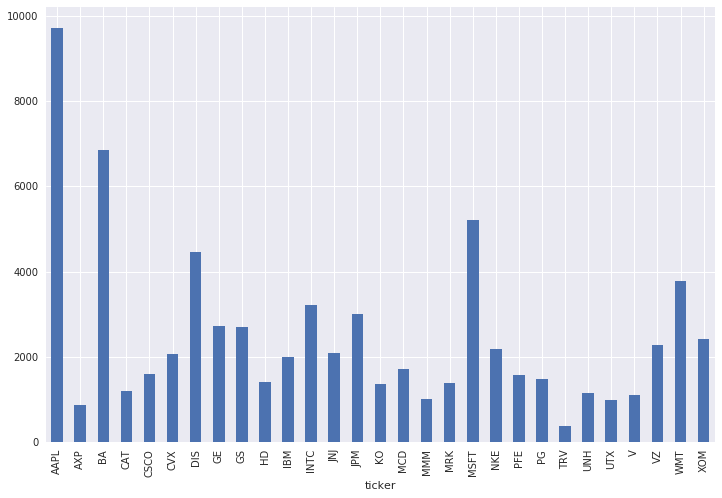

In [27]:
news_data.groupby('ticker').count()['date'].plot.bar(figsize=(12,8))

Here is sentiment distribution for all news we collected. It is obvious that the majority of them are positive sentiment and the number of news in range (0.0,0.1) is extremely high, which makes sense because most news uses an objective and neutral tone.

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


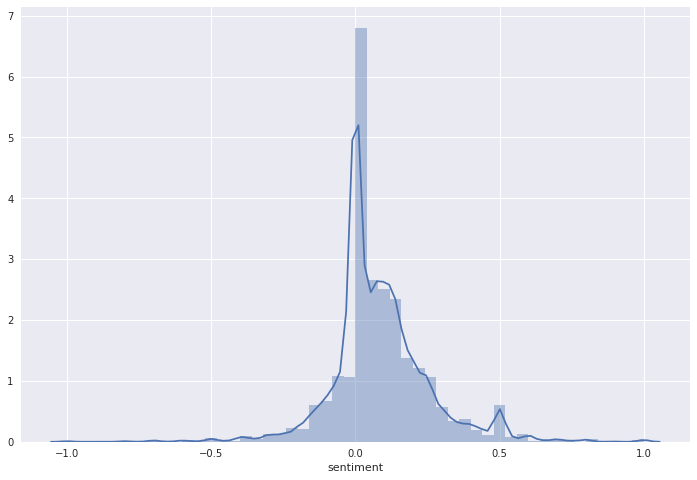

In [28]:
sns.set(rc={'figure.figsize':(12,8)})
sns.distplot(news_data['sentiment'])

## Put it together

Put all the collected and processed data above together, merge them by date.

In [30]:
news_data = joblib.load('processed_news_data')
news_data['date'] = pd.to_datetime(news_data['date'])
market_data = pd.read_csv('stock.csv')
market_data['Date'] = pd.to_datetime(market_data['Date'])
vix = pd.read_csv('VIX.csv')
vix['Date'] = pd.to_datetime(vix['Date'])
GICS_sector = pd.read_csv('GICS.csv')

df = pd.merge(news_data, vix[['Date', 'Adj Close']], left_on='date', right_on='Date')
df = df.merge(GICS_sector[['Symbol','GICS Sector']], left_on='ticker', right_on='Symbol')
df = df.merge(market_data, left_on=['ticker','date'], right_on=['ticker','Date'])
df.rename({'Adj Close_x': 'vix'}, axis='columns', inplace=True)
df = df[['ticker', 'date', 'processed_text', 'sentiment', 'word_count', 'vix', 'GICS Sector', 'his_1', 'his_2', 'his_3', 'his_4', 'change']]
df.head()

,ticker,date,processed_text,sentiment,word_count,vix,GICS Sector,his_1,his_2,his_3,his_4,change
0,MMM,2019-11-29,"[time, comb, portfolio, decide, year, loser, p...",-0.075000,12,12.62,Industrials,0.751706,0.945291,0.836041,1.158972,0
1,MMM,2019-11-29,"[general, electric, making, major, change, bru...",-0.190625,15,12.62,Industrials,0.751706,0.945291,0.836041,1.158972,0
2,MMM,2019-11-29,"[russell, etf, iwm, lagged, larger, p, etf, sp...",0.152554,599,12.62,Industrials,0.751706,0.945291,0.836041,1.158972,0
3,MMM,2019-11-27,"[bloomberg, opinion, deere, result, show, trou...",0.026289,422,11.75,Industrials,0.744403,1.014478,0.925828,1.125579,0
4,MMM,2019-11-26,"[share, abbvie, texas, instrument, extra, spac...",0.150000,12,11.54,Industrials,0.882839,1.039348,1.016882,1.107641,0


In summary, our input features are:

* **Stock Features**: Sector, VIX, 4 Historical average data points
* **News Features**: Word sequence, Sentiment, Word count

# Deep Learning Model

In this project, we built a deep learning model take all the features above as input and output the possible stock price movement. 


## Preparation

Before building the model, we need to do some preparation.

First, we transformed all the word sequences (each represented a news article) to padded numerical sequences with the same length. Each word is replaced by its index in the vocabulary dictionary. The length of sequence was decided by the length of longest word sequence. In our dataset, it's 5664.

In [32]:
max_len = df['word_count'].max()

def to_padded_sequence(docs, max_len=max_len):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(docs)
    docs = pad_sequences(sequences = tokenizer.texts_to_sequences(docs), maxlen = max_len, padding = 'post')
    return docs, tokenizer

Then we separate news text data with other auxiliary features, since they would be fed into the model in different places (will explain it later). We also transformed categorical variable to dummy variables.

In [33]:
# Separate into X, docs and y
cols = ['GICS Sector', 'vix', 'sentiment', 'word_count', 'his_1', 'his_2', 'his_3', 'his_4']
X = df[cols]
y = df['change']
docs = df['processed_text']
docs, tokenizer = to_padded_sequence(docs)

# Get Dummies
X = pd.get_dummies(columns = ['GICS Sector'], prefix="sector", data=X)
y = pd.get_dummies(columns=['change'], data=y)

# Split the data set into train and test data with the ratio of 7/3
# and keep the distribution of 3 classes same in train and test set.
X_train, X_test, y_train, y_test, docs_train, docs_test = train_test_split(X, y, docs, stratify=y, test_size=0.3)

Split the data set into train and test data with the ratio of 7/3, and keep the distribution of 3 classes same in train and test set.

Since our dataset was imbalanced, we used oversampling to make the number of samples in each class same in the training data. Additionally, to make all the features having the similar scale, we standardized them to 0-1.

In [35]:
def oversample(X, docs, y):
    # Get number of training points of the largest class
    largest_class = y.sum().idxmax()
    n = y[largest_class].sum()
    other_classes = y.drop(largest_class, axis=1) 
    # For each other class, create a dataframe of randomly sampled rows
    row_sample = [y.loc[y[col]==1].sample(n=n-y[col].sum(), replace=True) 
                  for col in other_classes.columns]
    row_sample.append(y)
    y = pd.concat(row_sample,axis=0)
    X = X.loc[y.index]
    docs = pd.DataFrame(docs, index=y_train.index).loc[y.index]
    return X, docs.values, y

In [37]:
auxiliary_feature = ['vix', 'sentiment', 'word_count', 'his_1', 'his_2', 'his_3', 'his_4']
x_scaler = StandardScaler()
X_train[auxiliary_feature] = x_scaler.fit_transform(X_train[auxiliary_feature])
X_test[auxiliary_feature] = x_scaler.transform(X_test[auxiliary_feature])

X_train, docs_train, y_train = oversample(X_train, docs_train, y_train)

num_aux_feature = len(X_train.columns)
output_dim = len(y_train.columns)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy 

Here are the shapes of our auxiliary features and target.

In [38]:
print(X_train.shape, y_train.shape)

(78081, 15) (78081, 3)


Now our news text is represented by a long sequence, in order to simplify the work, we chose to use word vectors to transform the word sequence to an embedding with lower dimension. We used the 100-dimension version of [Global Vectors for Word Representation](https://nlp.stanford.edu/projects/glove/). 

Here we loaded the GloVe word2vec dictionary: 

In [40]:
embedding_dim = 100

def load_embeddings(vec_file):
    print("Loading GloVe...")
    with open(vec_file,'r') as f:
        word2vec = {}
        for line in f:
            split_line = line.split()
            word = split_line[0]
            embedding = np.array([float(i) for i in split_line[1:]])
            word2vec[word] = embedding
        print("Loaded %d word vectors"%(len(word2vec)))
    return word2vec

word2vec = load_embeddings("glove.6B.100d.txt")

Loading GloVe...
Loaded 400000 word vectors


Then we found the vector representation of each word in our dataset using this word2vec dictionary, and built an embedding_matrix with shape `(vocab_size, embedding_dim)`, which will be passed to the Embedding layer in our model as weights.

In [41]:
not_found = 0
vocab_size = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    try:
        embedding_vector = word2vec[word]
        embedding_matrix[i] = embedding_vector
    except Exception:
        # if words are not found in GloVe vectors, their embeddings will be all-zeros.
        not_found += 1
print('number of not found words:', not_found)

number of not found words: 15308


In [42]:
# Save data
np.save("Data/docs_train.npy",docs_train)
np.save("Data/docs_test.npy",docs_test)

joblib.dump(X_train, "Data/X_train")
joblib.dump(X_test, "Data/X_test")

joblib.dump(y_train, "Data/y_train")
joblib.dump(y_test, "Data/y_test") 

np.save("Data/embedding_matrix.npy", embedding_matrix)

## Model Construction and Training

After all the above preparation, we were ready to construct our model! 

### Model Architecture

<img src="model.png" width="800"> 

Our model has two input layers, one is for news text (represented by a numerical suquence), the other is for remaining auxiliary features. The reason why we kept them separate is that we wanted to first transform the word sequence to the text embedding, extract useful information from the embedding, then combine the extracted features with other features. For extracting information from text embedding, we tried two methods, the first one is a fully connected layer, the second one is a RNN (bidirectional GRU ([gated recurrent unit](https://en.wikipedia.org/wiki/Gated_recurrent_unit)) layer followed by a batch normalization layer. Then the combined features would go through an MLP ([multilayer perceptron](https://en.wikipedia.org/wiki/Multilayer_perceptron)) to output the final results. The output layer is probabilities of three movements, from which we took the movement with the maximum possibility.

Other than accuracy, we add another metric, [AUC ROC](https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5), to our model, which will be evaluated later.

In [44]:
# Add AUC ROC to GLOBAL_VARIABLES collection, refer: https://github.com/keras-team/keras/issues/6050#issuecomment-329996505
def auc_roc(y_true, y_pred):
    value, update_op = tf.metrics.auc(y_true, y_pred)
    metric_vars = [i for i in tf.local_variables() if 'auc_roc' in i.name.split('/')[1]]

    # Add metric variables to GLOBAL_VARIABLES collection.
    # They will be initialized for new session.
    for v in metric_vars:
        tf.add_to_collection(tf.GraphKeys.GLOBAL_VARIABLES, v)

    # force to update metric values
    with tf.control_dependencies([update_op]):
        value = tf.identity(value)
        return value

def build_model(architecture, 
                max_len=max_len, vocab_size=vocab_size, embedding_dim=embedding_dim, embedding_matrix=embedding_matrix, 
                num_aux_feature=num_aux_feature, output_dim=output_dim):
    
    text_input= Input(shape=(max_len,))
    x_text = Embedding(input_dim = vocab_size,
                  output_dim = embedding_dim,
                  weights=[embedding_matrix],
                  input_length=max_len, 
                  trainable=False)(text_input)

    if architecture == 'mlp':
        x_text = Dense(32, activation='relu')(x_text)
        x_text = Dropout(0.2)(x_text)
        x_text = Flatten()(x_text)
    
    elif architecture == 'rnn':
        x_text = Bidirectional(CuDNNGRU(64, return_sequences=False), merge_mode='concat')(x_text)
        x_text = BatchNormalization()(x_text)
        
    auxiliary_input = Input(shape=(num_aux_feature,))
    x = concatenate([x_text, auxiliary_input])
    x = Dense(32, activation='relu')(x)
#     x = Dropout(0.2)(x)
    x = Dense(32, activation='relu')(x)
    x = Dense(16, activation='relu')(x)
    output = Dense(output_dim, activation='softmax')(x)
    
    model = Model(inputs=[text_input, auxiliary_input], outputs=[output])
    model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy', auc_roc])   
    
    return model

### Training

We trained the two models separately, each for 5 epochs.

(The following several cells of training code were run on a GPU device.)

#### MLP

In [45]:
# X_train = joblib.load("Data/X_train")
# y_train = joblib.load("Data/y_train")
# docs_train = np.load("Pickles/docs_train.npy")

mlp = build_model("mlp")
mlp_hist = mlp.fit([docs_train, X_train], y_train, batch_size=32, epochs=5, verbose=1)
mlp.save("Data/models/mlp_5.hdf5")











Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/5
78081/78081 [==============================] - 63s 807us/step - loss: 0.6242 - acc: 0.7319 - auc_roc: 0.8245
Epoch 2/5
78081/78081 [==============================] - 61s 783us/step - loss: 0.3864 - acc: 0.8486 - auc_roc: 0.9185
Epoch 3/5
78081/78081 [==============================] - 61s 783us/step - loss: 0.3320 - acc: 0.8694 - auc_roc: 0.9413
Epoch 4/5
78081/78081 [==============================] - 61s 777us/step - loss: 0.3250 - acc: 0.8772 - auc_roc: 0.9518
Epoch 5/5
78081/78081 [==============================] - 60s 775us/step - loss: 0.3160 - acc: 0.8829 - auc_roc: 0.9578


The metrics of MLP during training time were plotted as followed:

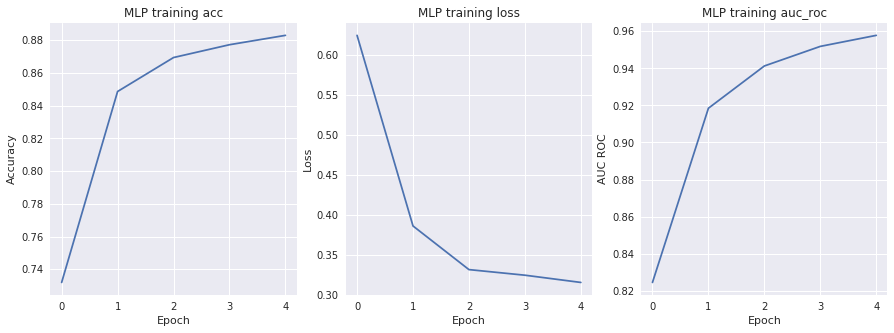

In [48]:
def plot_training_hist(model, history, metrics, x_label, y_labels):
    sns.set(font_scale=1)
    plt.figure(figsize=[15,5])
    for i, (metric, y_label) in enumerate(zip(metrics, y_labels)):
        plt.subplot(1,3,i+1)
        plt.plot(history.history[metric])
        plt.title(model+" training "+metric)
        plt.ylabel(y_label)
        plt.xlabel(x_label)
#     plt.tight_layout()
    plt.show()

plt.style.use("ggplot")

plot_training_hist("MLP", mlp_hist, ["acc", "loss", "auc_roc"], "Epoch", ["Accuracy", "Loss", "AUC ROC"])

#### RNN

In [49]:
rnn = build_model("rnn")
rnn_hist = rnn.fit([docs_train, X_train], y_train, batch_size=32, epochs=5, verbose=1)
rnn.save("Data/models/rnn_5.hdf5")

Epoch 1/5
78081/78081 [==============================] - 2458s 31ms/step - loss: 0.6004 - acc: 0.7434 - auc_roc: 0.8275
Epoch 2/5
78081/78081 [==============================] - 2453s 31ms/step - loss: 0.3557 - acc: 0.8530 - auc_roc: 0.9236
Epoch 3/5
78081/78081 [==============================] - 2454s 31ms/step - loss: 0.3116 - acc: 0.8675 - auc_roc: 0.9447
Epoch 4/5
78081/78081 [==============================] - 2455s 31ms/step - loss: 0.2921 - acc: 0.8742 - auc_roc: 0.9541
Epoch 5/5
78081/78081 [==============================] - 2453s 31ms/step - loss: 0.2784 - acc: 0.8799 - auc_roc: 0.9597


The metrics of RNN during training time were plotted as followed:

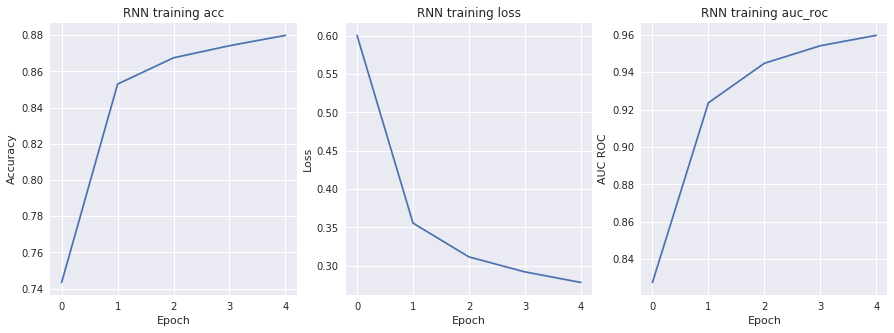

In [50]:
plot_training_hist("RNN", rnn_hist, ["acc", "loss", "auc_roc"], "Epoch", ["Accuracy", "Loss", "AUC ROC"])

## Test Results

After training for 5 epochs, we tested the two models on the test data. The test results are showed below:

In [50]:
# X_test = joblib.load("Data/X_test")
# y_test = joblib.load("Data/y_test")
# docs_test = np.load("Pickles/docs_test.npy")
# mlp = load_model("Data/models/mlp_5.hdf5", custom_objects={"auc_roc":auc_roc})
# rnn = load_model("Data/models/rnn_5.hdf5", custom_objects={"auc_roc":auc_roc})

In [51]:
res = mlp.evaluate([docs_test, X_test], y_test, batch_size=64)

print('MLP: Loss = {}, Accuracy = {}, AUC_ROC = {}'.format(res[0], res[1], res[2]))

20057/20057 [==============================] - 4s 202us/step
MLP: Loss = 0.6460917533282038, Accuracy = 0.775240564406343, AUC_ROC = 0.9589422766260215


In [52]:
res = rnn.evaluate([docs_test, X_test], y_test, batch_size=64)

print('RNN: Loss = {}, Accuracy = {}, AUC_ROC = {}'.format(res[0], res[1], res[2]))

20057/20057 [==============================] - 137s 7ms/step
RNN: Loss = 0.5618741142046667, Accuracy = 0.7878546143639639, AUC_ROC = 0.9660231300173464


Now we only predict a single piece of news's effect on the stock price performance. However, in our dataset, there are multiple news articles for the same company on a single day. So we decided to combine the output of different pieces of news by taking the average for three probabilities, then based on the new probabilities, pick the class with maximum probability.

For example, the output of news A is: [0.3, 0.3, 0.4], the output of news B is: [0.2, 0.5, 0.3]. Taking average, now the new probabilies are: [0.25, 0.4, 0.35], we will predict the second class. Using this way, we group all the outputs of the test data by company and date, then make a prediction using all the news for each company on each day, the accuracy is calculated below. As we can see, the accuracy was higher than before. 

In [53]:
def multi_news_accuarcy(model, model_name):
    y_true = np.array(y_test).argmax(1)
    y_pred = model.predict([docs_test, X_test])
    pred = pd.DataFrame(y_pred)
    X_test_original = df.loc[X_test.index]
    pred['ticker'] = list(X_test_original['ticker'])
    pred['date'] = list(X_test_original['date'])
    pred['y_true'] = y_true
    grouped_pred = pred.groupby(['ticker', 'date']).mean()[[0,1,2,'y_true']]
    y_pred = np.array(grouped_pred[[0,1,2]]).argmax(1)
    y_true = np.array(grouped_pred['y_true'])
    accuracy = (y_true==y_pred).sum()/len(y_true)
    print('{}: Using multiple news in a day, Accuracy = {}'.format(model_name, accuracy))

In [54]:
multi_news_accuarcy(mlp, 'MLP')

MLP: Using multiple news in a day, Accuracy = 0.8153057617532697


In [55]:
multi_news_accuarcy(rnn, 'RNN')

RNN: Using multiple news in a day, Accuracy = 0.8320219158713327


From the above results, we can find that both architectures can reach an accuracy above 80%, while the one with RNN layer are slightly better than MLP. This might be explained by the fact that RNN remembers each and every information through time so it is useful when dealing with sequential data.

We plotted the confusion matrix of the RNN model to show its performance in predicting each class. As we can see, although it was able to correctly predict around 80% of "Up" and "Flat" case, it performed badly in the "Down" case, having no big difference from random guessing. The reason is that even if we tried to handle the imbalanced data by using oversampling, the original "Down" data points are to few to learn patterns from. This should be an important area to be improved in future works.

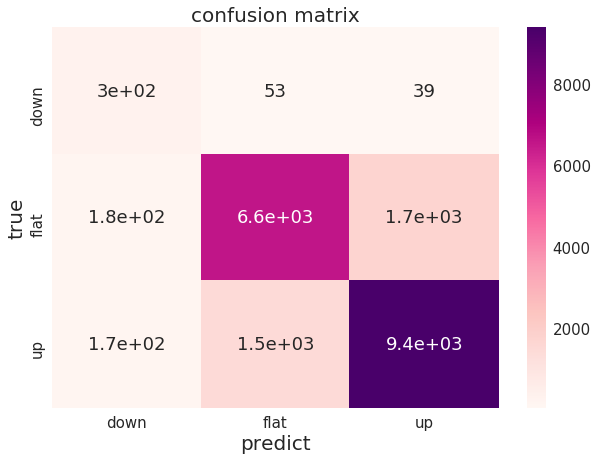

In [58]:
def compute_and_plot_cm(model):
    y_true = np.array(y_test).argmax(1)
    y_pred = model.predict([docs_test, X_test]).argmax(1)
    sns.set(font_scale=1.5)
    f, ax = plt.subplots(figsize=(10, 7))
    cm = confusion_matrix(y_true, y_pred, labels=[0,1,2])
    df_cm = pd.DataFrame(cm, index = ['down','flat','up'], columns = ['down','flat','up'])
    ax = sns.heatmap(df_cm, annot=True, cmap="RdPu")
    plt.title('confusion matrix',fontsize=20)
    plt.xlabel('predict',fontsize=20)
    plt.ylabel('true',fontsize=20)
    plt.show()
    
compute_and_plot_cm(rnn)

# Conclusion and Future Works

In conclusion, we got a significant improvement (around 132%) over a baseline random choice model (~33%), which indicates that using news to predict swings in companies' stock performance is **worth trying**, and there are many possibilities to explore:

* Have a better data set.

To fix the imbalanced dataset, we need more data points with "Down" label. We can also try to find a more reliable data source of news other than web scraping from a single website. In this project we only use 1-year's data for 29 companies, we can extend the scope by including more companies and longer time range in the future.

* Try other measurements of stock price movement

The current model only consider the short-term (next day) performance, and categorizes the output into simple up/down/flat without specifying the level of change. Therefore, future research efforts can focus on refining the prediction of price trends, having more detailed definition and measurement of price performance/trend/movement. Besides, future research can focus directly on the price itself, rather than the performance compared to the market.

* Explore more NLP and deep learning techniques

Our experiment shows that NLP and deep learning are useful in finding useful information from the text data, but we only tried some simple methods. In future works, more techniques can be explored, for example, instead of using word vectors to get news embedding, we can use a model to learn the embedding from the original word sequence (Doc2Vec), we can also try more complex models like LSTM and BERT.

# References

[1] Yusuf Aktan, Using NLP and Deep Learning to Predict Stock Price Movements, Towards Data Science, Jun 28, 2018. Retrieved from: https://towardsdatascience.com/using-nlp-and-deep-learning-to-predict-the-stock-market-64eb9229e102

[2] Mohan, Saloni, et al. "Stock Price Prediction Using News Sentiment Analysis." 2019 IEEE Fifth International Conference on Big Data Computing Service and Applications (BigDataService). IEEE, 2019.